In [2]:
import os
if os.getcwd().endswith('notebooks'):
  os.chdir('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
model_name = '001-rnn'

with open(f'./models/{model_name}_meta.json') as f:
  model_data = json.load(f)

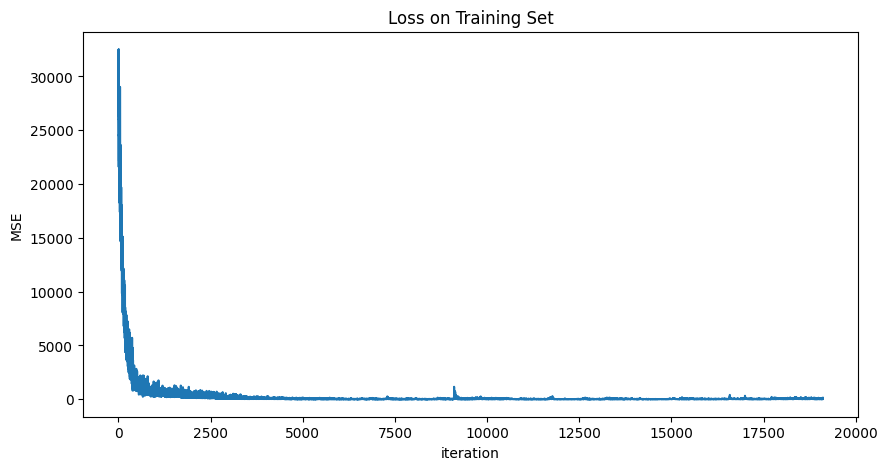

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(model_data['loss'])
plt.title('Loss on Training Set')
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.show()

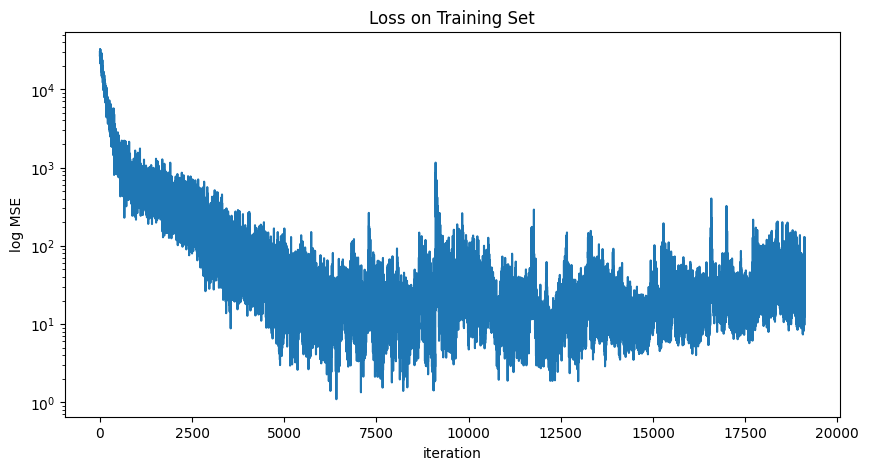

In [6]:
plt.figure(figsize=(10, 5))
sns.lineplot(model_data['loss'])
plt.title('Loss on Training Set')
plt.xlabel('iteration')
plt.ylabel('log MSE')
plt.yscale('log')
plt.show()

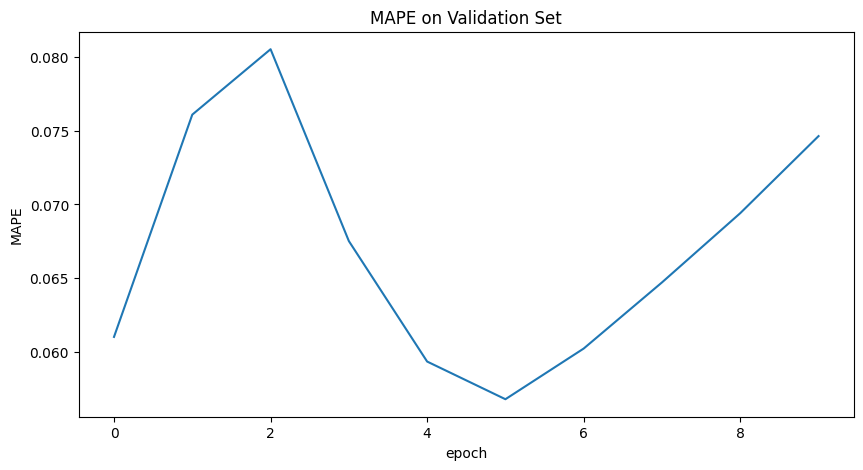

In [13]:
metric = 'mape'

plt.figure(figsize=(10, 5))
sns.lineplot(model_data['val_scores'][metric])
plt.title(metric.upper() + ' on Validation Set')
plt.xlabel('epoch')
plt.ylabel(metric.upper())
plt.show()